# Mariantonieta_IA – Voice to Text (ASR with CTC)

En este notebook entrenamos un modelo de reconocimiento automático de voz (ASR) en inglés,
usando CTC y el dataset LJSpeech, para integrarlo luego en el proyecto Mariantonieta_IA.


## Setup

In [1]:
pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

print("Setup listo!!")

Setup listo!!


## Load the LJSpeech Dataset

In [3]:
import os
# 1. Descargar y extraer LJSpeech
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

print("data_path:", data_path)

# 2. Decidir la carpeta base donde realmente están 'metadata.csv' y 'wavs'
#    Caso A: todo está directamente en data_path
base_path = data_path
metadata_direct = os.path.join(base_path, "metadata.csv")
wavs_direct = os.path.join(base_path, "wavs")

if not (os.path.isfile(metadata_direct) and os.path.isdir(wavs_direct)):
    # Caso B: están dentro de una subcarpeta LJSpeech-1.1 (como en tu entorno)
    base_path = os.path.join(data_path, "LJSpeech-1.1")

# 3. Construimos rutas finales correctas
metadata_path = os.path.join(base_path, "metadata.csv")
wavs_path = os.path.join(base_path, "wavs") + "/"

print("Using metadata_path:", metadata_path)
print("Using wavs_path:", wavs_path)

# 4. Leer metadata y parsearla
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]

# Mezclar filas (shuffle)
metadata_df = metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Total samples in LJSpeech:", len(metadata_df))
metadata_df.head(3)


2748572632/2748572632 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
data_path: /root/.keras/datasets/LJSpeech-1_extracted
Using metadata_path: /root/.keras/datasets/LJSpeech-1_extracted/LJSpeech-1.1/metadata.csv
Using wavs_path: /root/.keras/datasets/LJSpeech-1_extracted/LJSpeech-1.1/wavs/
Total samples in LJSpeech: 13100


,file_name,normalized_transcription
0,LJ015-0247,"At that station the safes were given out, heav..."
1,LJ028-0475,No traces of its moat have appeared.
2,LJ013-0049,"A notorious miser, Robert Smith, had recently ..."


In [26]:
subset_size = 13100

metadata_subset = metadata_df.head(subset_size).copy()

print("Subset size:", len(metadata_subset))
metadata_subset.head(3)

Subset size: 13100


,file_name,normalized_transcription
0,LJ015-0247,"At that station the safes were given out, heav..."
1,LJ028-0475,No traces of its moat have appeared.
2,LJ013-0049,"A notorious miser, Robert Smith, had recently ..."


### Train / Validation split

In [27]:
# Usamos el subset reducido para hacer el split
total_samples = len(metadata_subset)
split = int(total_samples * 0.90)  # 90% train, 10% val

df_train = metadata_subset[:split].copy()
df_val = metadata_subset[split:].copy()

print(f"Total samples in subset    : {total_samples}")
print(f"Size of the training set   : {len(df_train)}")
print(f"Size of the validation set : {len(df_val)}")

df_train.head(3), df_val.head(3)

Total samples in subset    : 13100
Size of the training set   : 11790
Size of the validation set : 1310


(    file_name                           normalized_transcription
 0  LJ015-0247  At that station the safes were given out, heav...
 1  LJ028-0475               No traces of its moat have appeared.
 2  LJ013-0049  A notorious miser, Robert Smith, had recently ...,
         file_name                           normalized_transcription
 11790  LJ006-0208  There was also a good supply of Bibles and pra...
 11791  LJ003-0014  Quarreling among the debtors was not unfrequen...
 11792  LJ033-0014  Lee Harvey Oswald lived in a roominghouse in D...)

## Preprocessing

### Build vocabulary and char mappings


In [ ]:
# Conjunto de caracteres que aceptaremos en las transcripciones
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# Mapeo de caracter -> número (índice entero)
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# Mapeo de número -> caracter (para decodificar de vuelta a texto)
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_(' ')] (size =31)


In [28]:
# Tamaño de la ventana (en muestras) para la STFT
frame_length = 256
# Paso entre ventanas (en muestras)
frame_step = 160
# Tamaño de la FFT (si no se da, se usa la menor potencia de 2 que cubra frame_length)
fft_length = 384

def encode_single_sample(wav_file, label):
    """
    A partir del nombre de archivo y su texto:
    - Carga el audio .wav y lo convierte en un espectrograma normalizado.
    - Convierte el texto en una secuencia de índices (enteros).
    Devuelve: (spectrograma, label_codificada)
    """

    ###########################################
    ##  Procesamiento del audio
    ##########################################
    # 1. Construir la ruta completa del archivo .wav y leerlo
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decodificar el archivo .wav a un tensor de audio
    audio, _ = tf.audio.decode_wav(file)  # audio: [num_muestras, 1]
    # 3. Quitar la dimensión extra para dejarlo en [num_muestras]
    audio = tf.squeeze(audio, axis=-1)
    # 4. Asegurar que el tipo sea float32
    audio = tf.cast(audio, tf.float32)
    # 5. Calcular el espectrograma usando STFT
    spectrogram = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length,
    )
    # 6. Quedarnos solo con la magnitud (módulo de los valores complejos)
    spectrogram = tf.abs(spectrogram)
    # 7. Aplicar una raíz para comprimir el rango dinámico (suavizar diferencias grandes)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 8. Normalizar: restar media y dividir por desviación estándar
    means = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Procesamiento del texto (label)
    ##########################################
    # 9. Convertir el texto a minúsculas
    label = tf.strings.lower(label)
    # 10. Separar el texto en caracteres individuales (Unicode)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 11. Mapear cada caracter a su índice numérico
    label = char_to_num(label)

    # 12. Devolver el par (entrada_procesada, etiqueta_procesada)
    return spectrogram, label

## Creating Dataset objects


In [29]:
batch_size = 32

# Dataset de ENTRENAMIENTO
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        list(df_train["file_name"]),
        list(df_train["normalized_transcription"])
    )
)

# Aplicamos el preprocesamiento y preparamos los batches
train_dataset = (
    train_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Dataset de VALIDACIÓN
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (
        list(df_val["file_name"]),
        list(df_val["normalized_transcription"])
    )
)

validation_dataset = (
    validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [30]:
for X_batch, y_batch in train_dataset.take(1):
    print("Batch spectrograms:", X_batch.shape)
    print("Batch labels      :", y_batch.shape)

Batch spectrograms: (32, 1273, 193)
Batch labels      : (32, 151)


## Visualize the data


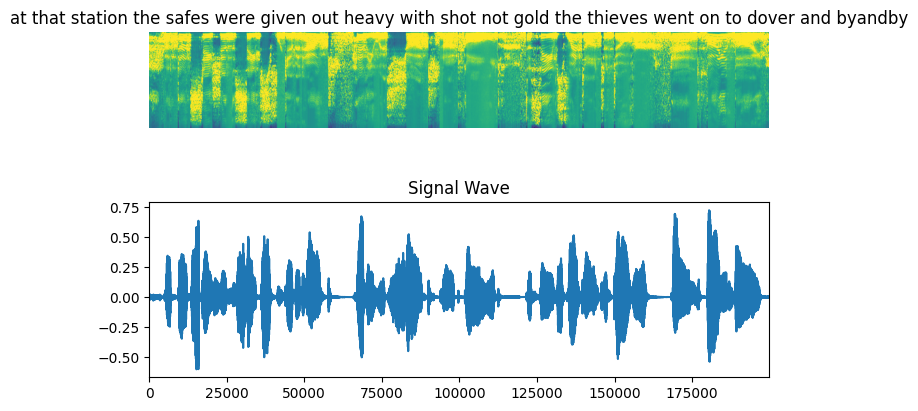

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Build CTC Model


### Define CTC loss


In [9]:
# Función de pérdida basada en CTC (Connectionist Temporal Classification)
def CTCLoss(y_true, y_pred):
    """
    Calcula la pérdida CTC para un batch.
    y_true: secuencias de etiquetas (índices) con padding
    y_pred: logits del modelo (distribución sobre el vocabulario en cada paso de tiempo)
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Calculamos la pérdida CTC por secuencia y devolvemos el promedio
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


### Define model architecture (DeepSpeech2-style)


In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """
    Construye un modelo similar a DeepSpeech2:
    - CNN 2D sobre el espectrograma
    - Varias capas GRU bidireccionales
    - Capa densa final con softmax sobre el vocabulario
    """

    # Entrada: espectrograma de tamaño variable en el tiempo, con 'input_dim' frecuencias
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expandimos la dimensión para usar Conv2D: (tiempo, frecuencias) -> (tiempo, frecuencias, 1)
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Capa convolucional 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Capa convolucional 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Aplanamos las dimensiones espaciales (frecuencias × filtros) para alimentar a las RNN
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # Capas RNN
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Capa densa intermedia
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Capa de clasificación final
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Construimos el modelo Keras
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Optimizador Adam con learning rate pequeño
    opt = keras.optimizers.Adam(learning_rate=1e-4)

    # Compilamos el modelo usando nuestra función de pérdida CTC
    model.compile(optimizer=opt, loss=CTCLoss)

    return model

### Build and inspect the model


In [ ]:
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

## Train and Evaluate


### Decode predictions (utility function)


In [10]:
# Función de utilidad para decodificar las salidas del modelo (logits) a texto
def decode_batch_predictions(pred):
    """
    pred: tensor de forma (batch, time, vocab_size+1)
    Devuelve una lista de strings (predicciones decodificadas).
    """
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Usamos decodificación CTC "greedy"
    results = keras.backend.ctc_decode(
        pred,
        input_length=input_len,
        greedy=True
    )[0][0]
    # Convertimos cada secuencia de índices en texto
    output_text = []
    for result in results:
        text = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(text)

    return output_text

### Callback to monitor WER on validation set


In [11]:
class CallbackEval(keras.callbacks.Callback):
    """Callback que calcula el WER en el conjunto de validación al final de cada época."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset  # tf.data.Dataset de validación

    def on_epoch_end(self, epoch, logs=None):
        predictions = []
        targets = []

        # Recorremos todo el dataset de validación
        for batch in self.dataset:
            X, y = batch  # X = espectrogramas, y = labels codificados

            # Usamos el modelo actual para predecir
            batch_predictions = self.model.predict(X)

            # Decodificamos las predicciones a texto
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)

            # También convertimos las etiquetas verdaderas a texto
            for label in y:
                label_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                targets.append(label_text)

        # Calculamos el WER usando jiwer
        wer_score = wer(targets, predictions)

        print("-" * 100)
        print(f"Epoch {epoch + 1} - Word Error Rate (WER): {wer_score:.4f}")
        print("-" * 100)

        # Mostramos un par de ejemplos aleatorios
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

### Train model


In [ ]:
epochs = 3

# Callback para evaluar en el conjunto de validación al final de cada época
validation_callback = CallbackEval(validation_dataset)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
----------------------------------------------------------------------------------------------------
Epoch 1 - Word Error Rate (WER): 1.0000
----------------------------------------------------------------------------------------------------
Target    : the purchase by palmer of strychnia was proved
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : the privileges of the master's side also disappeared fees were nominally abolished and garnish was scotched although not yet killed outright
Prediction: 
----------------------------

In [ ]:
total_epochs = 10
already_trained = 3

# Callback de validación (lo podemos reutilizar)
validation_callback = CallbackEval(validation_dataset)

history_more = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=already_trained,
    callbacks=[validation_callback],
)

Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
----------------------------------------------------------------------------------------------------
Epoch 4 - Word Error Rate (WER): 1.0000
----------------------------------------------------------------------------------------------------
Target    : the court claimed the power to declare it unconstitutional and did so declare it
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : if any man presumed to turn in too early
Prediction: 
------------------------------------------------------------------------------------

In [ ]:
already_trained = 10
total_epochs = 20

# Volvemos a crear el callback de validación
validation_callback = CallbackEval(validation_dataset)

history_more_20 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=already_trained,
    callbacks=[validation_callback],
)

Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
----------------------------------------------------------------------------------------------------
Epoch 11 - Word Error Rate (WER): 0.8340
----------------------------------------------------------------------------------------------------
Target    : this allotment division will consider all of the recommendations submitted to it
Prediction: thi salomen dvion l conir oof the recmenation soited toi
----------------------------------------------------------------------------------------------------
Target    : neither marina oswald nor ruth paine saw oswald in the garage
Prediction: ni the

In [ ]:
already_trained = 20
total_epochs = 30

# Volvemos a crear el callback de validación
validation_callback = CallbackEval(validation_dataset)

history_more_20 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=already_trained,
    callbacks=[validation_callback],
)

Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
----------------------------------------------------------------------------------------------------
Epoch 21 - Word Error Rate (WER): 0.7026
----------------------------------------------------------------------------------------------------
Target    : was substantially true
Prediction: was of stentaly tro
----------------------------------------------------------------------------------------------------
Target    : an attempt to cover only the most obvious points of possible ambush along the route in dallas might well have included the texas school book depository building
Prediction: an

## More training

### Load model and vocabulary

In [4]:
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras

# 1. Definir de nuevo la función de pérdida CTC
def CTCLoss(y_true, y_pred):
    # Longitud del batch
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    # Longitud de la secuencia de salida del modelo (tiempo)
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    # Longitud de la secuencia de etiquetas
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Longitudes repetidas para cada elemento del batch
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Pérdida CTC por secuencia
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

# 2. Cargar el modelo que ya entrenaste (30 épocas)
model = keras.models.load_model("mariantonieta_asr_ctc.h5", compile=False)

# 3. Compilarlo otra vez para seguir entrenando
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss=CTCLoss)

# 4. Cargar vocabulario de caracteres
with open("vocab_characters.json", "r") as f:
    characters = json.load(f)

# 5. Recrear capas de mapeo caracter <-> número
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)

print("Modelo cargado y compilado. Tamaño vocabulario:", char_to_num.vocabulary_size())

Modelo cargado y compilado. Tamaño vocabulario: 31


In [13]:
already_trained = 30
total_epochs = 40

# Volvemos a crear el callback de validación
validation_callback = CallbackEval(validation_dataset)

history_more_20 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=already_trained,
    callbacks=[validation_callback],
)

Epoch 31/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
----------------------------------------------------------------------------------------------------
Epoch 31 - Word Error Rate (WER): 0.5491
----------------------------------------------------------------------------------------------------
Target    : w

In [31]:
already_trained = 40
total_epochs = 45

# Volvemos a crear el callback de validación
validation_callback = CallbackEval(validation_dataset)

history_more_20 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=already_trained,
    callbacks=[validation_callback],
)

Epoch 41/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━

In [32]:
already_trained = 45
total_epochs = 50

# Volvemos a crear el callback de validación
validation_callback = CallbackEval(validation_dataset)

history_more_20 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=already_trained,
    callbacks=[validation_callback],
)

Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━

## Final evaluation on validation set


In [33]:
predictions = []
targets = []

# Recorremos TODO el conjunto de validación
for batch in validation_dataset:
    X, y = batch   # X = espectrogramas, y = labels codificados como índices

    # 1. El modelo genera predicciones para este batch
    batch_predictions = model.predict(X)

    # 2. Decodificamos las salidas del modelo (logits) a texto
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

    # 3. Decodificamos también las etiquetas verdaderas (y) a texto
    for label in y:
        label_text = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label_text)

# Calculamos el WER global en todo el conjunto de validación
wer_score = wer(targets, predictions)

print("-" * 100)
print(f"Word Error Rate (WER) en validación: {wer_score:.4f}")
print("-" * 100)

# Mostramos 5 ejemplos aleatorios de Target vs Prediction
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [35]:
# Elegimos una fila al azar del conjunto de validación
sample = df_val.sample(1, random_state=123).iloc[0]

file_id = sample["file_name"]                  # ID del wav, ej: "LJ001-0001"
true_text = sample["normalized_transcription"] # Transcripción real

print("ID del archivo:", file_id)
print("Transcripción real:")
print(true_text)

# Ruta completa al archivo wav
wav_file_path = wavs_path + file_id + ".wav"
print("Ruta del wav:", wav_file_path)

ID del archivo: LJ026-0036
Transcripción real:
and then a balance must be struck and the doubtful form placed in the kingdom with which it has, on the whole, most points in common.
Ruta del wav: /root/.keras/datasets/LJSpeech-1_extracted/LJSpeech-1.1/wavs/LJ026-0036.wav


In [36]:
from IPython.display import Audio
Audio(filename=wav_file_path)


In [37]:
def preprocess_audio_for_inference(file_path: str) -> tf.Tensor:
    """
    Carga un archivo .wav y lo convierte en el espectrograma normalizado
    que espera el modelo. Devuelve un tensor con shape (1, time, freq_bins).
    """

    # Leer archivo wav
    file = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(file)  # [num_muestras, 1]

    # Quitar dimensión extra y convertir a float32
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    # Calcular espectrograma (misma STFT que en el entrenamiento)
    spectrogram = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length,
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # Normalización (igual que antes)
    means = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    # Añadir dimensión batch: (time, freq) -> (1, time, freq)
    spectrogram = tf.expand_dims(spectrogram, axis=0)

    return spectrogram

In [38]:
# Preprocesamos el audio
input_spec = preprocess_audio_for_inference(wav_file_path)

# El modelo hace la predicción
pred = model.predict(input_spec)

# Usamos la misma función que ya tienes para decodificar batches
pred_text = decode_batch_predictions(pred)[0]  # [0] porque solo hay un ejemplo

print("-" * 100)
print("TRANSCRIPCIÓN REAL:")
print(true_text)
print("-" * 100)
print("PREDICCIÓN DEL MODELO:")
print(pred_text)
print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
----------------------------------------------------------------------------------------------------
TRANSCRIPCIÓN REAL:
and then a balance must be struck and the doubtful form placed in the kingdom with which it has, on the whole, most points in common.
----------------------------------------------------------------------------------------------------
PREDICCIÓN DEL MODELO:
and then a balance must be struck and the dout four form placed in the kingdom with which it has on the hole most poin n
----------------------------------------------------------------------------------------------------


## Load the model

In [ ]:
!pip install librosa soundfile

In [39]:
import librosa
import soundfile as sf

def convert_to_ljspeech_like(input_path, output_path="user_22050_mono.wav", target_sr=22050):
    """
    Convierte un .wav cualquiera a:
    - mono
    - 22050 Hz
    y lo guarda en output_path.
    Devuelve la ruta del nuevo archivo.
    """
    # Cargar audio con librosa, forzando sample rate y mono
    audio, sr = librosa.load(input_path, sr=target_sr, mono=True)
    print(f"Audio cargado. Sample rate original (según librosa): {sr}, duración: {len(audio)/sr:.2f} s")

    # Guardar en nuevo archivo con el formato deseado
    sf.write(output_path, audio, target_sr)
    print(f"Archivo convertido guardado en: {output_path}")
    return output_path

In [40]:
def preprocess_audio_for_inference(file_path: str) -> tf.Tensor:
    # Leer archivo .wav
    file = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(file)

    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length,
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    means = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    spectrogram = tf.expand_dims(spectrogram, axis=0)
    return spectrogram

In [41]:
from google.colab import files
from IPython.display import Audio

# 1) Subir el archivo .wav grabado por ti
uploaded = files.upload()  # seleccionas tu archivo .wav
audio_filename = list(uploaded.keys())[0]
print("Archivo original subido:", audio_filename)

# Opcional: escucharlo
#display(Audio(filename=audio_filename))

# 2) Convertirlo a mono + 22050 Hz
formatted_path = convert_to_ljspeech_like(audio_filename, output_path="user_22050_mono.wav")

# 3) Preprocesar el audio convertido (usando la función que ya tenías)
input_spec = preprocess_audio_for_inference(formatted_path)

# 4) Pasar por el modelo
pred = model.predict(input_spec)

# 5) Decodificar predicción
pred_text = decode_batch_predictions(pred)[0]

print("-" * 100)
print("ARCHIVO ORIGINAL:", audio_filename)
print("ARCHIVO FORMATEADO:", formatted_path)
print("-" * 100)
print("PREDICCIÓN DEL MODELO (transcripción):")
print(pred_text)
print("-" * 100)

Saving record_out (1).wav to record_out (1).wav
Archivo original subido: record_out (1).wav
Audio cargado. Sample rate original (según librosa): 22050, duración: 6.12 s
Archivo convertido guardado en: user_22050_mono.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
----------------------------------------------------------------------------------------------------
ARCHIVO ORIGINAL: record_out (1).wav
ARCHIVO FORMATEADO: user_22050_mono.wav
----------------------------------------------------------------------------------------------------
PREDICCIÓN DEL MODELO (transcripción):
utodus was of fvhot tho the vuste msen
----------------------------------------------------------------------------------------------------


## Conclusiones del modelo de voz a texto

En este proyecto se entrenó un modelo tipo DeepSpeech2 (CNN + RNN + CTC) usando el dataset LJSpeech durante 50 épocas. El modelo alcanzó una **Word Error Rate (WER) = 0.25 en el conjunto de validación**, lo que significa que, aunque todavía comete errores, es capaz de generar transcripciones bastante cercanas al texto real. En muchos ejemplos del propio dataset la predicción es casi idéntica a la oración objetivo, con fallos principalmente ortográficos o fonéticos, pero manteniendo la estructura de la frase y el sentido general.

Sin embargo, al probar con audios externos grabados por mí, incluso ajustando el formato (mono, 22050 Hz), el rendimiento baja de forma importante. Esto se debe a varias limitaciones claras: el modelo fue entrenado solo con una locutora, en condiciones de estudio y con un tipo de inglés muy específico, mientras que mi voz tiene otro acento, otro micrófono y más ruido de fondo. Es decir, el modelo funciona bien **dentro del dominio de LJSpeech**, pero generaliza mal a condiciones reales distintas.

En resumen, el modelo entrenado cumple su objetivo como **prueba de concepto** de un sistema de reconocimiento de voz: implementa todo el flujo de audio → espectrograma → CTC → texto y obtiene buenos resultados en su conjunto de validación.


## Save the model

In [34]:
# Guarda el modelo como un solo archivo HDF5
model.save("mariantonieta_asr_ctc_v3.h5")

import os
print("Archivos en el directorio actual:")
print(os.listdir())

Archivos en el directorio actual:
['.config', 'mariantonieta_asr_ctc_v2.h5', 'vocab_characters.json', '.ipynb_checkpoints', 'mariantonieta_asr_ctc.h5', 'mariantonieta_asr_ctc_v3.h5', 'sample_data']


In [ ]:
import json

with open("vocab_characters.json", "w") as f:
    json.dump(characters, f)

from google.colab import files
files.download("vocab_characters.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>